# CSDS 133: Introduction to Data Science and Engineering
## Fall 2024
## Homework - 3
## Due: 11.59.59pm Sunday October 13, 2024

We learn two ways to collect data: API and Webscraping. In this assingment, you will collect data both with API and Web Scraping methods. Once you collect your data, you will create a Data Frame from the data and run basic statistics on your data (same as HW2 question 20). Then you will visualize your data choosing the best chart type.

#### 2. Scraping

In [1]:
############
### INFO ###
############

# All code used below is solely written by me, Trevor Nichols,
# with no outside resources other than official documentation for libraries used
# All data collected is freely available with open websites

# This script is meant to scrape wikipedia articles for their links in order to graph traverse wikipedia
# Originally, I meant to visualize this graph of wikipedia articles, but quickly realized this is difficult through scraping alone
# Thus, I changed the purpose to visualize the number of links to other wikipedia articles from a given article and see the distribution

# I utilize PostgreSQL as my database to store the scraped data as it allows me to quickly use multiple threads for parallel scraping
# This script WILL NOT RUN without a PostgreSQL database setup and the necessary connection values stored in a .env file, particularly
#  the DB_URI connection string, DB_NAME, DB_USER, and DB_PASSWORD

In [1]:
####################
### Dependencies ###
####################

import requests as rq
from dotenv import load_dotenv
import os
import json
import pandas as pd
from io import StringIO
from IPython.display import display
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as bs
import sqlite3 as sql
import psycopg as pg
from dotenv import load_dotenv
import asyncio
import nest_asyncio

In [2]:
#####################
### General Setup ###
#####################

nest_asyncio.apply()
load_dotenv()

True

In [3]:
###########################
### Setup PostgreSQL DB ###
###########################

# Make a connection to the database
activateCon = lambda : pg.Connection.connect(os.getenv("DB_URI"), cursor_factory=pg.ClientCursor)
con = activateCon()
cur = con.cursor()

# Define possible status codes for WikiPages
status = {
    "complete": 0,
    "queued": 1,
    "incomplete": 2
}

# Create tables in the database if they don't exist
cur.execute("CREATE TABLE IF NOT EXISTS WikiPages (ID BIGSERIAL PRIMARY KEY, Title TEXT NOT NULL UNIQUE, Status INTEGER)")
cur.execute("CREATE TABLE IF NOT EXISTS Links (LinkID BIGSERIAL PRIMARY KEY, Origin INTEGER NOT NULL REFERENCES WikiPages(ID), Target INTEGER NOT NULL REFERENCES WikiPages(ID), UNIQUE(Origin, Target))")
cur.execute('''
    UPDATE WikiPages
    SET Status = %s
    WHERE Status = %s
''', (status["incomplete"], status["queued"]))
con.commit()
con.close()

In [4]:
#######################################
### Setup Data Collection Functions ###
#######################################

# The source we are getting data from
getWiki = lambda n : f"https://en.wikipedia.org/wiki/{n}"

# Define the number of max threads to use
threads = 200

loop = asyncio.get_event_loop()

# Define asynchronous function decorator to allow for asynchronous execution within the loop
def asyn(f):
    global loop
    def wrapped(*args, **kwargs):
        global loop
        return loop.run_in_executor(None, f, *args, **kwargs)
    return wrapped

def aawait(f):
    global loop
    return loop.run_until_complete(f)


def get_wiki_content(name):
    '''
    Fetch the content of a Wikipedia page and return a list of links.
    '''
    fetched = rq.get(getWiki(name))
    if fetched.status_code != 200:
        raise Exception(f"Failed to fetch page for {name}")
    b = bs(fetched.content, 'html.parser')
    return [j.split("#")[0] for j in [i["href"][6:] for i in b.select("div#mw-content-text a[href^=\"/wiki/\"]")] if ":" not in j]

def add_wikis(names, con, cur):
    '''
    Add new Wikipedia pages and their associated links to the database.
    '''
    args_str = ','.join(cur.mogrify("(%s,%s)", (name, status["incomplete"])) for name in names)
    cur.execute('''
            INSERT INTO WikiPages (Title, Status) VALUES
        ''' + args_str + " ON CONFLICT DO NOTHING")
    con.commit()
    return True

def add_links(orig, names, con, cur):
    '''
    Add new links between Wikipedia pages
    '''
    cur.executemany('''
        INSERT INTO Links (Origin, Target) SELECT a.ID, b.ID
            FROM WikiPages AS a, WikiPages AS b
            WHERE a.Title = %s AND b.Title = %s
            ON CONFLICT DO NOTHING
    ''', [(orig, name) for name in names])
    con.commit()
    return True

def dispatch_one(name, con, cur):
    '''
    Fetch the content of a Wikipedia page and add it to the database
    '''
    cur.execute("UPDATE WikiPages SET Status = %s WHERE Title = %s", (status["queued"], name))
    con.commit()
    try:
        links = get_wiki_content(name)
    except Exception as e:
        cur.execute("UPDATE WikiPages SET Status = %s WHERE Title = %s", (status["incomplete"], name))
        con.commit()
        return False
    toAdd = add_wikis(links, con, cur)
    toLink = add_links(name, links, con, cur)
    cur.execute("UPDATE WikiPages SET Status = %s WHERE Title = %s", (status["complete"], name))
    con.commit()

def dispatch_first(i, con, cur):
    '''
    Fetch the content of an unprocessed Wikipedia page and add it to the database.
    '''
    # Obtain a random incomplete page from the database
    cur.execute("SELECT Title FROM WikiPages TABLESAMPLE BERNOULLI (1) WHERE Status = %s", (status["incomplete"],))
    n = cur.fetchone()
    if n:
        return dispatch_one(n[0], con, cur)
    return False

@asyn
def dispatch_thread(i):
    '''
    Start a thread to fetch and process Wikipedia pages
    '''
    con = activateCon()
    cur = con.cursor()
    with con.pipeline():
        while True:
            dispatch_first(i, con, cur)

# @asyn
def dispatch_fetchers():
    '''
    Start a number of threads to fetch and process Wikipedia pages
    '''
    return [dispatch_thread(i) for i in range(threads)]


In [8]:
#######################
### Data Collection ###
#######################

# Add one page to begin with to the database, I chose the CWRU page
con.close()
con = activateCon()
cur = con.cursor()
a = add_wikis(["Case_Western_Reserve_University"], con, cur)
con.close()
b = dispatch_fetchers()

# @asyn
# def kill_connection_after_time(t):
#     aawait(asyncio.sleep(t))
#     del pipe
#     con.close()
#     exit(0)

# killer = kill_connection_after_time(10)

# Display status of fetchers
while True:
    print(f"Working... {[i.done() for i in b]}")
    aawait(asyncio.sleep(2))
con.close()


Working... [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, F

#### 2.b. Store your data into data frame:

In [5]:
#########################
### Pull Data from DB ###
#########################

# Get number of links per origin
con = activateCon()
cur = con.cursor()

LinksPerPage = cur.execute('''
    SELECT COUNT(Target) FROM Links
    GROUP BY Origin
''').fetchall()
con.close()

In [6]:
#####################################
### Convert to a Pandas DataFrame ###
#####################################

df = pd.DataFrame([i[0] for i in LinksPerPage])
display(df)


,0
0,45
1,303
2,178
3,10
4,890
...,...
51376,9
51377,178
51378,541
51379,15


In [7]:
##################
### Statistics ###
##################

display(df.describe())


,0
count,51381.000000
mean,249.499387
std,283.290327
min,1.000000
25%,69.000000
50%,161.000000
75%,317.000000
max,5140.000000


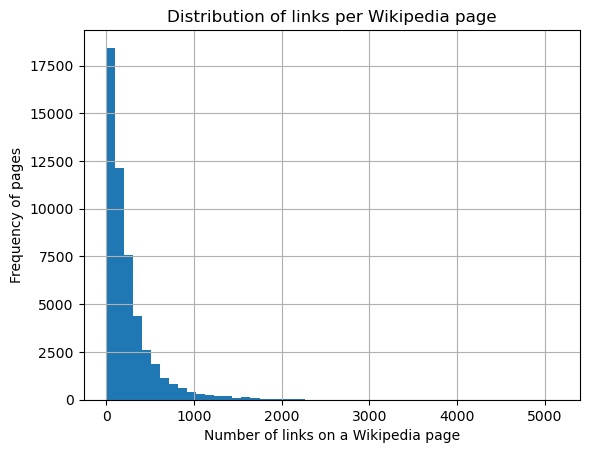

In [10]:
#####################
### Visualization ###
#####################

# I use a histogram to visualize the distribution of links per Wikipedia page
# Histograms allow us to see the spread of the data and identify any potential outliers or skewness

hist = df.hist(bins=50)

plt.xlabel("Number of links on a Wikipedia page")
plt.ylabel("Frequency of pages")
plt.title("Distribution of links per Wikipedia page")
plt.show()